# Recommendation Systems

- **`Content Based Recommendation`**
  - Recommends items based on their characteristics and a user's preferences for those characteristics.
  - For example, a movie recommender might suggest films with similar genres or actors to ones a user has liked in the past.

- **`Collaborative Filtering`**
  - recommends items based on the preferences of similar users.
  - It doesn't require knowledge of the items themselves, just information about user interactions.
  - For example, a music streaming service might recommend songs that other users with similar tastes have enjoyed.

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,mlxtend,omegaconf --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
pandas   : 2.2.1
polars   : 0.20.18
mlxtend  : 0.23.1
omegaconf: 2.3.0

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(n=200)

warnings.filterwarnings("ignore")


# auto reload imports# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(500)

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [3]:
from tqdm import tqdm
from typing import Generator


def process_text(text: list[str]) -> list[str]:
    """
    Process a list of text lines to extract product IDs and categories.

    Parameters
    ----------
    text : list[str]
        A list of strings representing lines of text to process.

    Returns
    -------
    list[str]
        A list of strings, each containing a product ID and its associated category.
    """
    result: list[str] = []
    # Starts with a capital letter and then lowercase letters
    pattern: re.Pattern[str] = re.compile(r"^[A-Z][a-z]+")
    prod_id: str = ""

    for line in tqdm(text, desc="Processing Text", unit="line", ncols=100):
        line: str = line.strip()
        if len(line.split(",")) == 1 and not pattern.match(line):
            prod_id = line
        elif pattern.match(line):
            result.append(f"{prod_id}: {line}")

    return result


def parse_keys_values(filename: str) -> Generator[dict[str, str], None, None]:
    """
    Parse key-value pairs from a file.

    Parameters
    ----------
    filename : str
        The path to the file to be parsed.

    Yields
    ------
    dict[str, str]
        A dictionary containing key-value pairs parsed from the file.

    """
    entry: dict[str, str] = {}
    f = open(filename, "rb")

    # Iterate over all lines in the file.
    for l in f:
        l = l.strip()
        # The key/value pairs are separated by a colon.
        colonPos: int = l.find(b":")
        if colonPos == -1:
            yield entry
            entry = {}
            continue
        key: str = l[:colonPos].decode("latin-1")
        value: str = l[colonPos + 2 :].decode("latin-1")
        entry[key] = value
    yield entry


def read_reviews(path: str, num: int = -1) -> pl.DataFrame:
    """
    Read reviews from a file and return them as a Polars DataFrame.

    Parameters
    ----------
    path : str
        The path to the file containing the reviews.
    num : int, optional
        The number of reviews to read. If -1, read all reviews. Default is -1.

    Returns
    -------
    pl.DataFrame
        A Polars DataFrame containing the parsed reviews.

    """
    i: int = 0
    df: dict[int, dict[str, str]] = {}
    for d in parse_keys_values(path):
        df[i] = d
        i += 1
        if i == num:
            break
    result: pl.DataFrame = pl.DataFrame([x for x in df.values()])
    return result

In [4]:
fp: str = "../../data/prod_categories.parquet"

prod_categories: pl.DataFrame = pl.read_parquet(fp)
print(f"{prod_categories.shape = }")
prod_categories.head(3)

prod_categories.shape = (2437878, 2)


product_id,product_category
str,str
"""B00005AL88""","""Cookware, Cookware Sets, Kitchen & Dining, Home & Kitchen"""
"""B000002ERS""","""Music, World Music Music, Latin Music"""
"""B000PR126O""","""Jewelry, Charms"""


In [5]:
# Set verbosity level
pl.Config.set_fmt_str_lengths(100)

polars.config.Config

In [6]:
fp: str = "../../data/Music_small.parquet"
music_df: pl.DataFrame = (
    pl.read_parquet(fp)
    .sample(fraction=0.2, shuffle=True, seed=123)
    .with_columns(
        summary=pl.col("summary").str.to_lowercase(),
        text=pl.col("text").str.to_lowercase(),
    )
)
print(f"{music_df.shape = }")
music_df.head(2)

music_df.shape = (1279270, 10)


productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B00004VVN6""","""Elvis - '68 Comeback Special (1968)""","""unknown""","""A1VMEBPPFUU0J7""","""C. Manson""","""1/1""",5.0,"""960595200""","""no strap for you""","""i could easily slobber all over my blue suede shoes praising this one, but let me just sum it up by…"
"""B000003BD7""","""A Christmas Gift for You from Phil Spector""","""12.14""","""A13HAJYO0FO0LQ""","""Aj Watson""","""3/5""",5.0,"""1258416000""","""great in mono""","""my copy of sony's remaster of this xmas classic arrived today. i have to say, this 2009 remaster fr…"


### Data Cleaning

In [7]:
music_df.head()

productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B00004VVN6""","""Elvis - '68 Comeback Special (1968)""","""unknown""","""A1VMEBPPFUU0J7""","""C. Manson""","""1/1""",5.0,"""960595200""","""no strap for you""","""i could easily slobber all over my blue suede shoes praising this one, but let me just sum it up by…"
"""B000003BD7""","""A Christmas Gift for You from Phil Spector""","""12.14""","""A13HAJYO0FO0LQ""","""Aj Watson""","""3/5""",5.0,"""1258416000""","""great in mono""","""my copy of sony's remaster of this xmas classic arrived today. i have to say, this 2009 remaster fr…"
"""B000AMUUSU""","""Hello Waveforms""","""unknown""","""A2X192PNI73QWI""","""David L. Reade""","""0/5""",5.0,"""1131408000""","""you are absolutely right.....""","""i'm referring to the comments of the first reviewer, he's right: what's up with orbit's website not…"
"""B00000EGZR""","""About Face""","""unknown""","""A1P6559HS6RN6""","""Dustbuny48 ""Music Soul""""","""2/2""",4.0,"""1189296000""","""a most wonderful surprise""","""while most modern day pink floyd fans only know david gilmour as a major contributor to their later…"
"""B0000013GH""","""Secrets""","""11.98""","""A105NYRPZGNJ19""","""F. Juergens""","""3/17""",2.0,"""1046217600""","""overrated!""","""to me, toni braxton is one of the most overrated singers of the 90s, and this album is far worse th…"


In [8]:
# Check for unique product and userId entries
p_id: str = "B000058A81"
user_id: str = "A18C9SNLZWVBIE"
music_df.filter((pl.col("productId").eq(p_id) & pl.col("userId").eq(user_id)))

productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str


In [9]:
# We want a:
# unique user-product pair.
# unique user-title pair.
# unique product-title pair.

print(f"[Before data cleaning]: {music_df.shape}")

# Remove duplicates
music_cleaned_df: pl.DataFrame = music_df.unique(subset=["userId", "productId"])
# music_cleaned_df = music_cleaned_df.unique(subset=["userId", "title"])
# music_cleaned_df = music_cleaned_df.unique(subset=["productId", "title"])

print(f"[After data cleaning]: {music_cleaned_df.shape}")

[Before data cleaning]: (1279270, 10)
[After data cleaning]: (1108029, 10)


In [10]:
music_cleaned_df.head()

productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B001O0TMOK""","""Thomas & Friends: A Big Day for Thomas (2008)""","""13.48""","""A2DTG3VI3THZFS""","""penrph""","""2/5""",1.0,"""1242777600""","""dissapointment""","""if you're getting this dvd for the trains like i was don't bother unless you're looking for 2 thoma…"
"""B000069AZM""","""Parachutes (Enhanced)""","""unknown""","""A1UC15EDQ30TNB""","""Ryan Mitchell""","""0/0""",5.0,"""1060041600""","""one of the best albums i've bought all year""","""coldplay's &quot;parachutes&quot; is simply beautiful. first, i bought &quot;a rush of blood to the…"
"""B000O76PG2""","""Iowa""","""unknown""","""AX5KAH824C7OV""","""jake""","""3/4""",5.0,"""1059782400""","""you dont know what real metal is""","""iowa is a good album, u all say they didnt put the songs together very well but they did, u all jus…"
"""B0000AGWG0""","""Speakerboxxx: Love Below""","""unknown""","""A1LBL3FA5PX7EN""","""Davy""","""2/4""",4.0,"""1091577600""","""might've given it 3.5 if i could've""","""i didn't think it could be true, but it is: big boi's half is better than dre's. _speakerboxxx_ top…"
"""B0002B74UG""","""Level Headed""","""unknown""","""A2T2LY2HHWBIGO""","""Rkbluez ""Steve A""""","""6/6""",4.0,"""1227916800""","""great album...just ok remaster from lemon""","""this is a great album by the sweet with some really good songs...it's got a couple of duds like lad…"


In [11]:
# Check the unique userIDs
music_cleaned_df["userId"].value_counts(sort=True).head()

userId,count
str,u32
"""unknown""",85993
"""A9Q28YTLYREO7""",2085
"""A2WQY1B8ZS7QRZ""",1030
"""A8IFUOL8S9BZC""",1022
"""A2U49LUUY4IKQQ""",899


In [12]:
# Check the unique title
music_cleaned_df["title"].value_counts(sort=True).head(20)

title,count
str,u32
"""Greatest Hits""",4081
"""Best of""",2374
"""St. Anger""",1957
"""Kind of Blue""",1835
"""Hybrid Theory""",1738
"""No Strings Attached""",1501
"""Come Away With Me""",1449
"""Let Go""",1190
"""Fallen""",1178


In [13]:
# Drop the unwanted userIDs
rem_str: str = "unknown"
rem_str_2: str = ""
print(f"[Before data cleaning]: {music_cleaned_df.shape}")
music_cleaned_df = music_cleaned_df.filter(pl.col("userId").ne(rem_str))
music_cleaned_df = music_cleaned_df.filter(pl.col("title").ne(rem_str_2))
print(f"[After data cleaning]: {music_cleaned_df.shape}")

[Before data cleaning]: (1108029, 10)
[After data cleaning]: (1021768, 10)


In [14]:
music_cleaned_df.head()

productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B001O0TMOK""","""Thomas & Friends: A Big Day for Thomas (2008)""","""13.48""","""A2DTG3VI3THZFS""","""penrph""","""2/5""",1.0,"""1242777600""","""dissapointment""","""if you're getting this dvd for the trains like i was don't bother unless you're looking for 2 thoma…"
"""B000069AZM""","""Parachutes (Enhanced)""","""unknown""","""A1UC15EDQ30TNB""","""Ryan Mitchell""","""0/0""",5.0,"""1060041600""","""one of the best albums i've bought all year""","""coldplay's &quot;parachutes&quot; is simply beautiful. first, i bought &quot;a rush of blood to the…"
"""B000O76PG2""","""Iowa""","""unknown""","""AX5KAH824C7OV""","""jake""","""3/4""",5.0,"""1059782400""","""you dont know what real metal is""","""iowa is a good album, u all say they didnt put the songs together very well but they did, u all jus…"
"""B0000AGWG0""","""Speakerboxxx: Love Below""","""unknown""","""A1LBL3FA5PX7EN""","""Davy""","""2/4""",4.0,"""1091577600""","""might've given it 3.5 if i could've""","""i didn't think it could be true, but it is: big boi's half is better than dre's. _speakerboxxx_ top…"
"""B0002B74UG""","""Level Headed""","""unknown""","""A2T2LY2HHWBIGO""","""Rkbluez ""Steve A""""","""6/6""",4.0,"""1227916800""","""great album...just ok remaster from lemon""","""this is a great album by the sweet with some really good songs...it's got a couple of duds like lad…"


In [15]:
# Check the unique titles
# music_cleaned_df["title"].value_counts(sort=True).slice(20, 40)
titles: list[dict[str, int]] = (
    music_cleaned_df["title"].value_counts(sort=True).to_dicts()
)
titles = sorted(titles, key=lambda x: x["title"], reverse=True)
titles[980:1000]

[{'title': 'Youngsters', 'count': 1},
 {'title': 'Youngest of The Camp', 'count': 1},
 {'title': 'Youngest in Charge', 'count': 2},
 {'title': 'Youngest Was the Most Loved', 'count': 1},
 {'title': 'Younger and Younger [VHS] (1993)', 'count': 1},
 {'title': 'Younger Than Yesterday [Vinyl]', 'count': 16},
 {'title': 'Younger Than Yesterday', 'count': 69},
 {'title': 'Younger Louder & Snottyer', 'count': 1},
 {'title': 'Younger Girl', 'count': 1},
 {'title': 'Younger Days: Definitive Fatal Flowers', 'count': 1},
 {'title': 'Younger And Younger', 'count': 1},
 {'title': 'Youngbloods/Earth Music/Elephant Mountain', 'count': 3},
 {'title': 'Youngblood', 'count': 3},
 {'title': 'Young, Rich and Dangerous', 'count': 3},
 {'title': 'Young, Rich & Dangerous', 'count': 3},
 {'title': 'Young, Gifted and Black', 'count': 4},
 {'title': 'Young, Fly & Flashy, Vol. 1 [Vinyl]', 'count': 7},
 {'title': 'Young, Fly & Flashy Vol 1', 'count': 2},
 {'title': 'Young for Eternity', 'count': 12},
 {'title': '

In [16]:
text: str = "zoo rave"
music_cleaned_df.filter(pl.col("title").str.to_lowercase().str.contains(text))

productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B00000E9GW""","""Zoo Rave 2""","""2.99""","""A1DTAWBG9UTVWR""","""""mn2nmixr""""","""2/2""",5.0,"""1015200000""","""perfecto""","""first of all, this album is from 1993, so late 90's is impossible. a great album packed with a vari…"
"""B00000099A""","""Zoo Rave II""","""unknown""","""A1DTAWBG9UTVWR""","""""mn2nmixr""""","""2/2""",5.0,"""1015200000""","""perfecto""","""first of all, this album is from 1993, so late 90's is impossible. a great album packed with a vari…"
"""B00000E9GW""","""Zoo Rave 2""","""2.99""","""A3F6L8ANIGHCAV""","""B. Lynch ""the_onewhoknows""""","""1/2""",5.0,"""981590400""","""worth seeking out""","""while the tunes here are all from the mid to late 1990's, they were cutting-edge in nearly any sens…"
"""B00000098Q""","""Zoo Rave, Vol. 1 [Vinyl]""","""unknown""","""A1SFF3DSLJVIEW""","""Ross H. Goodwin ""Digitally Natured Audio""""","""5/5""",5.0,"""1136678400""","""nostalgic frequencies....""","""i originally bought this as a cassette in 93. back then i loved every moment of the cd, in retrospe…"
"""B00000099A""","""Zoo Rave II""","""unknown""","""A3010KGHW804ZD""","""Craig Froehle""","""1/1""",3.0,"""980035200""","""typical dance techno -- not bad, not great""","""this disc was published by bmg records and all tracks were produced by the artists specifically for…"


### Apply Levenshtein Distance

- Levenshtein Distance is a string metric used to measure the difference between two sequences.
- It calculates the `minimum number of single-character edits` (`insertions`, `deletions`, or `substitutions`) required to change one word into another.
- It provides a quantitative measure of how dissimilar two strings are, which can be very useful in recommendation systems, especially for handling `typos` or `slight variations` in text input.
- It's an effective way to find close matches even when there are small differences between strings.

In [17]:
def levenshtein_distance(s1: str, s2: str) -> int:
    """
    Calculate the Levenshtein distance between two strings.

    Parameters
    ----------
    s1 : str
        The first string.
    s2 : str
        The second string.

    Returns
    -------
    int
        The Levenshtein distance between s1 and s2.

    Example
    -------
    >>> levenshtein_distance("kitten", "sitting")
    3
    """
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row: list[int] = list(range(len(s2) + 1))
    for i, c1 in enumerate(s1):
        current_row: list[int] = [i + 1]
        for j, c2 in enumerate(s2):
            insertions: int = previous_row[j + 1] + 1
            deletions: int = current_row[j] + 1
            substitutions: int = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]


def compute_string_similarity(s1: str, s2: str) -> float:
    """
    Compute the similarity between two strings based on Levenshtein distance.

    Parameters
    ----------
    s1 : str
        The first string.
    s2 : str
        The second string.

    Returns
    -------
    float
        A similarity score between 0 and 1, where 1 indicates identical strings.
    """
    distance: int = levenshtein_distance(s1, s2)
    max_length: int = max(len(s1), len(s2))
    similarity: float = 1 - (distance / max_length)
    return round(similarity, 4)

In [18]:
s1, s2 = "friend", "fiend"
distance: int = levenshtein_distance(s1=s1, s2=s2)
print(f"{distance = }")

similarity: float = compute_string_similarity(s1=s1, s2=s2)
print(f"{similarity = }")

distance = 1
similarity = 0.8333


In [19]:
temp_df: pl.DataFrame = pl.DataFrame(
    data={
        "title": [
            "spider man",
            "Spider-Man",
            "Spiderman",
            "Anikulapo",
            "Aniku la po",
        ],
        "ratings": [5, 5, 4, 3, 3],
    }
)
temp_df

title,ratings
str,i64
"""spider man""",5
"""Spider-Man""",5
"""Spiderman""",4
"""Anikulapo""",3
"""Aniku la po""",3


In [20]:
temp_df = temp_df.with_columns(title=pl.col("title").str.to_lowercase())
uniq_titles: list[str] = temp_df["title"].unique().to_list()
schema: dict[str, Any] = {"title_1": str, "title_2": str, "similarity": pl.Float32}
similarity_df: pl.DataFrame = pl.DataFrame(schema=schema)
similarity_df

title_1,title_2,similarity
str,str,f32


In [21]:
# Calculate similarity

result: list[dict[str, Any]] = []
threshold: float = 0.8

for idx, title_ in enumerate(uniq_titles):
    for n_title_ in uniq_titles[idx + 1 :]:
        score: float = compute_string_similarity(title_, n_title_)
        if score >= threshold:
            result.append({"title_1": title_, "title_2": n_title_, "similarity": score})
d: pl.DataFrame = pl.DataFrame(result, schema=schema)
similarity_df = pl.concat([similarity_df, d]).sort(by="title_1", descending=False)
similarity_df

title_1,title_2,similarity
str,str,f32
"""anikulapo""","""aniku la po""",0.8182
"""spider-man""","""spiderman""",0.9
"""spider-man""","""spider man""",0.9
"""spiderman""","""spider man""",0.9


In [22]:
def compute_similarity_matrix(
    unique_titles: list[str], threshold: float = 0.8
) -> pl.DataFrame:
    """
    Compute similarity matrix for unique titles.

    Parameters
    ----------
    unique_titles : list[str]
        List of unique titles to compare.
    threshold : float, optional
        Similarity threshold for including pairs, by default 0.8.

    Returns
    -------
    pl.DataFrame
        DataFrame containing similarity scores for title pairs above the threshold.
    """
    schema: dict[str, Any] = {"title_1": str, "title_2": str, "similarity": pl.Float32}
    result: list[dict[str, Any]] = []

    for idx, title_ in enumerate(unique_titles):
        for n_title_ in unique_titles[idx + 1 :]:
            score: float = compute_string_similarity(title_, n_title_)
            if score >= threshold:
                result.append(
                    {"title_1": title_, "title_2": n_title_, "similarity": score}
                )

    d: pl.DataFrame = pl.DataFrame(result, schema=schema)
    similarity_df: pl.DataFrame = pl.DataFrame(data=d, schema=schema).sort(
        by="title_1", descending=False
    )
    return similarity_df

In [23]:
def create_title_mapping(similarity_list: list[dict[str, str]]) -> dict[str, str]:
    """
    Create a mapping of variant titles to their canonical forms.

    Parameters
    ----------
    similarity_list : list[dict[str, str]]
        A list of dictionaries, where each dictionary contains
        'title_1' and 'title_2' keys with string values.

    Returns
    -------
    dict[str, str]
        A dictionary mapping variant titles to their canonical forms.

    Notes
    -----
    The canonical form is chosen as the shorter of the two titles.
    """
    mapping: dict[str, str] = {}

    for item in similarity_list:
        title_1: str = item["title_1"]
        title_2: str = item["title_2"]

        # Choose the shorter title as the canonical form
        if len(title_1) <= len(title_2):
            canonical: str = title_1
            variant: str = title_2
        else:
            canonical: str = title_2
            variant: str = title_1

        mapping[variant] = canonical

    return mapping


def replace_similar(title: str, mapping: dict[str, str]) -> str:
    return mapping.get(title, title)

In [24]:
similarity_df: pl.DataFrame = compute_similarity_matrix(
    unique_titles=uniq_titles, threshold=0.75
)
similarity_df

title_1,title_2,similarity
str,str,f32
"""anikulapo""","""aniku la po""",0.8182
"""spider-man""","""spiderman""",0.9
"""spider-man""","""spider man""",0.9
"""spiderman""","""spider man""",0.9


In [25]:
mapping: dict[str, str] = create_title_mapping(similarity_list=similarity_df.to_dicts())
mapping

{'aniku la po': 'anikulapo',
 'spider-man': 'spiderman',
 'spider man': 'spiderman'}

In [26]:
# Apply the replacement to the DataFrame
temp_df = temp_df.with_columns(
    title=pl.col("title").map_elements(
        lambda x: replace_similar(x, mapping), return_dtype=pl.Utf8
    )
)
temp_df

title,ratings
str,i64
"""spiderman""",5
"""spiderman""",5
"""spiderman""",4
"""anikulapo""",3
"""anikulapo""",3


#### Apply To the Data

In [27]:
# music_cleaned_df.write_parquet("music_data_vsm.parquet")

# Load similarities
similarity_df: pl.DataFrame = pl.read_csv("similar_titles.csv")
print(f"{similarity_df.shape = }")
similarity_df.head()

similarity_df.shape = (48587, 3)


title_1,title_2,similarity
str,str,f64
"""""Buck Owens - All-Time Greatest Hits, Vol.2""""","""""Buck Owens - All-Time Greatest Hits, Vol.3""""",0.875
"""""Buck Owens - All-Time Greatest Hits, Vol.2""""","""""Buck Owens - All-Time Greatest Hits, Vol.1""""",0.9023
"""""Buck Owens - All-Time Greatest Hits, Vol.3""""","""""Buck Owens - All-Time Greatest Hits, Vol.1""""",0.8906
"""""Dudes"" The Original Motion Picture Soundtrack Album""","""Dudes: The Original Motion Picture Soundtrack Album""",0.875
"""""La Vie En Rose""""","""La Vie En Rose""",0.8672


In [28]:
# Ignore patterns with numbers.
# e.g. bad boys 2 vs bad boys 3
similarity_df = similarity_df.filter(
    (
        ~(
            pl.col("title_1").str.contains(
                r"\w{1,20}\s*\w{1,20}[\s\.\'\-\:#,]*\w{0,3}\d{1,2}"
            )
        )
        & ~(
            pl.col("title_2").str.contains(
                r"\w{1,20}\s*\w{1,20}[\s\.\'\-\:#,]*\w{0,3}\d{1,2}"
            )
        )
        & (pl.col("similarity").lt(1))
    )
)
print(f"{similarity_df.shape = }")
similarity_df.describe()

similarity_df.shape = (7019, 3)


statistic,title_1,title_2,similarity
str,str,str,f64
"""count""","""7019""","""7019""",7019.0
"""null_count""","""0""","""0""",0.0
"""mean""",null,null,0.865919
"""std""",null,null,0.043697
"""min""","""""Dudes"" The Original Motion Picture Soundtrack Album""","""""Can't Complain""""",0.8008
"""25%""",null,null,0.8281
"""50%""",null,null,0.8594
"""75%""",null,null,0.8984
"""max""","""stylistics""","""the Collection""",0.9961


In [29]:
similarity_df.head(20)

title_1,title_2,similarity
str,str,f64
"""""Dudes"" The Original Motion Picture Soundtrack Album""","""Dudes: The Original Motion Picture Soundtrack Album""",0.875
"""""La Vie En Rose""""","""La Vie En Rose""",0.8672
"""""The Song Is You""""","""The Song Is You""",0.8633
"""""Until The End Of Time""""","""Until The End Of Time""",0.9141
"""# 1 Movie Love Songs""","""#1 Movie Love Songs""",0.8242
"""& Along Came Jones""","""And Along Came Jones""",0.8281
"""& It's Christmas""","""It's Christmas""",0.8516
"""'94 Mobsta's""","""94 Mobsta's""",0.9023
"""'Igginbottom's Wrench""","""Igginbottom's Wrench""",0.9453


In [30]:
print("[INFO]: Creating title mapping")
mapping: dict[str, str] = create_title_mapping(similarity_list=similarity_df.to_dicts())
mapping

[INFO]: Creating title mapping


{'"Dudes" The Original Motion Picture Soundtrack Album': 'Dudes: The Original Motion Picture Soundtrack Album',
 '"La Vie En Rose"': 'La Vie En Rose',
 '"The Song Is You"': 'The Song Is You',
 '"Until The End Of Time"': 'Until The End Of Time',
 '# 1 Movie Love Songs': '#1 Movie Love Songs',
 'And Along Came Jones': '& Along Came Jones',
 "& It's Christmas": "It's Christmas",
 "'94 Mobsta's": "94 Mobsta's",
 "'Igginbottom's Wrench": "Igginbottom's Wrench",
 '(Music From) The Connection': 'Music From The Connection',
 '(Self-Titled)': 'Self-Titled',
 "(What's the Story) Morning Glory?": "(What's The Story) Morning Glory?",
 '...From the Beginning': 'From the Beginning',
 '...In Pursuit of Excellence': 'In Pursuit of Excellence',
 '...Radio Silence': 'Radio Silence',
 '...The Amplification of Self Gratification': 'Amplification of Self Gratification',
 '.Enetics': 'Enetics',
 '30 [Vinyl]': '0 [Vinyl]',
 '21 [Vinyl]': '1 [Vinyl]',
 '#1 [Vinyl]': '1 [Vinyl]',
 '30 De Coleccion': '10 De Col

In [31]:
# Apply the replacement to the DataFrame
print("[INFO]: Replacing similar titles...")
music_cleaned_df = music_cleaned_df.with_columns(
    title=pl.col("title")
    .map_elements(lambda x: replace_similar(x, mapping), return_dtype=pl.Utf8)
    .str.to_lowercase()
)
music_cleaned_df.head()

[INFO]: Replacing similar titles...


productId,title,price,userId,profileName,helpfulness,score,time,summary,text
str,str,str,str,str,str,f32,str,str,str
"""B001O0TMOK""","""thomas & friends: a big day for thomas (2008)""","""13.48""","""A2DTG3VI3THZFS""","""penrph""","""2/5""",1.0,"""1242777600""","""dissapointment""","""if you're getting this dvd for the trains like i was don't bother unless you're looking for 2 thoma…"
"""B000069AZM""","""parachutes (enhanced)""","""unknown""","""A1UC15EDQ30TNB""","""Ryan Mitchell""","""0/0""",5.0,"""1060041600""","""one of the best albums i've bought all year""","""coldplay's &quot;parachutes&quot; is simply beautiful. first, i bought &quot;a rush of blood to the…"
"""B000O76PG2""","""iowa""","""unknown""","""AX5KAH824C7OV""","""jake""","""3/4""",5.0,"""1059782400""","""you dont know what real metal is""","""iowa is a good album, u all say they didnt put the songs together very well but they did, u all jus…"
"""B0000AGWG0""","""speakerboxxx: love below""","""unknown""","""A1LBL3FA5PX7EN""","""Davy""","""2/4""",4.0,"""1091577600""","""might've given it 3.5 if i could've""","""i didn't think it could be true, but it is: big boi's half is better than dre's. _speakerboxxx_ top…"
"""B0002B74UG""","""level headed""","""unknown""","""A2T2LY2HHWBIGO""","""Rkbluez ""Steve A""""","""6/6""",4.0,"""1227916800""","""great album...just ok remaster from lemon""","""this is a great album by the sweet with some really good songs...it's got a couple of duds like lad…"


In [32]:
merged_df: pl.DataFrame = music_cleaned_df.join(
    prod_categories, left_on="productId", right_on="product_id", how="left"
)
merged_df = merged_df.filter(
    pl.col("product_category").str.to_lowercase().str.contains("music")
).with_columns(product_category=pl.col("product_category").str.to_lowercase())
print(f"{merged_df.shape = }")

merged_df.head()

merged_df.shape = (1021768, 11)


productId,title,price,userId,profileName,helpfulness,score,time,summary,text,product_category
str,str,str,str,str,str,f32,str,str,str,str
"""B001O0TMOK""","""thomas & friends: a big day for thomas (2008)""","""13.48""","""A2DTG3VI3THZFS""","""penrph""","""2/5""",1.0,"""1242777600""","""dissapointment""","""if you're getting this dvd for the trains like i was don't bother unless you're looking for 2 thoma…","""tv, movies & tv music, children's music"""
"""B000069AZM""","""parachutes (enhanced)""","""unknown""","""A1UC15EDQ30TNB""","""Ryan Mitchell""","""0/0""",5.0,"""1060041600""","""one of the best albums i've bought all year""","""coldplay's &quot;parachutes&quot; is simply beautiful. first, i bought &quot;a rush of blood to the…","""music, alternative rock"""
"""B000O76PG2""","""iowa""","""unknown""","""AX5KAH824C7OV""","""jake""","""3/4""",5.0,"""1059782400""","""you dont know what real metal is""","""iowa is a good album, u all say they didnt put the songs together very well but they did, u all jus…","""music, hard rock & metal music, pop"""
"""B0000AGWG0""","""speakerboxxx: love below""","""unknown""","""A1LBL3FA5PX7EN""","""Davy""","""2/4""",4.0,"""1091577600""","""might've given it 3.5 if i could've""","""i didn't think it could be true, but it is: big boi's half is better than dre's. _speakerboxxx_ top…","""music, rap & hip-hop music, pop music, r&b"""
"""B0002B74UG""","""level headed""","""unknown""","""A2T2LY2HHWBIGO""","""Rkbluez ""Steve A""""","""6/6""",4.0,"""1227916800""","""great album...just ok remaster from lemon""","""this is a great album by the sweet with some really good songs...it's got a couple of duds like lad…","""music, hard rock & metal music, classic rock music, rock music, pop"""


In [33]:
# Unique products
merged_df["productId"].n_unique()

257353

In [34]:
pat: str = r"(,|\|)"
categories_str: str = " | ".join(merged_df["product_category"].to_list())
pattern: re.Pattern[str | Any] = re.compile(pat)
categories_list: list[str] = [
    x.strip() for x in pattern.split(categories_str) if x.strip() not in [",", "|"]
]
categories_df: pl.DataFrame = pl.DataFrame(
    list(set(categories_list)), schema={"category": pl.Utf8}
)

categories_df.head()

category
str
"""stress management meditation"""
"""rock drums & percussion"""
"""miscellaneous fitness & dieting"""
"""literature & fiction music"""
"""computers & accessories music"""


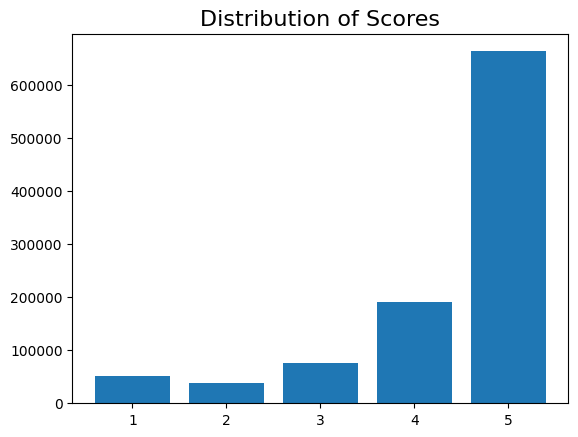

In [35]:
scores_df: pl.DataFrame = merged_df["score"].value_counts()

plt.bar(scores_df["score"], scores_df["count"])
plt.title("Distribution of Scores", fontsize=16)
plt.show()

In [36]:
ratings_df: pl.DataFrame = merged_df.group_by("productId").agg(
    (
        pl.col("score").len().alias("count"),
        pl.col("score").mean().round(2).alias("avg_score"),
    )
)

ratings_df.head()

productId,count,avg_score
str,u32,f32
"""B00004SPRO""",2,5.0
"""B0007LPSNQ""",1,4.0
"""B000001091""",3,4.33
"""B0000047GL""",1,5.0
"""B000NQRV5S""",2,5.0


In [37]:
ratings_df.describe()

statistic,productId,count,avg_score
str,str,f64,f64
"""count""","""257353""",257353.0,257353.0
"""null_count""","""0""",0.0,0.0
"""mean""",null,3.970298,4.400377
"""std""",null,11.452291,0.857439
"""min""","""0005224896""",1.0,1.0
"""25%""",null,1.0,4.0
"""50%""",null,1.0,4.8
"""75%""",null,3.0,5.0
"""max""","""B006B9REH6""",658.0,5.0


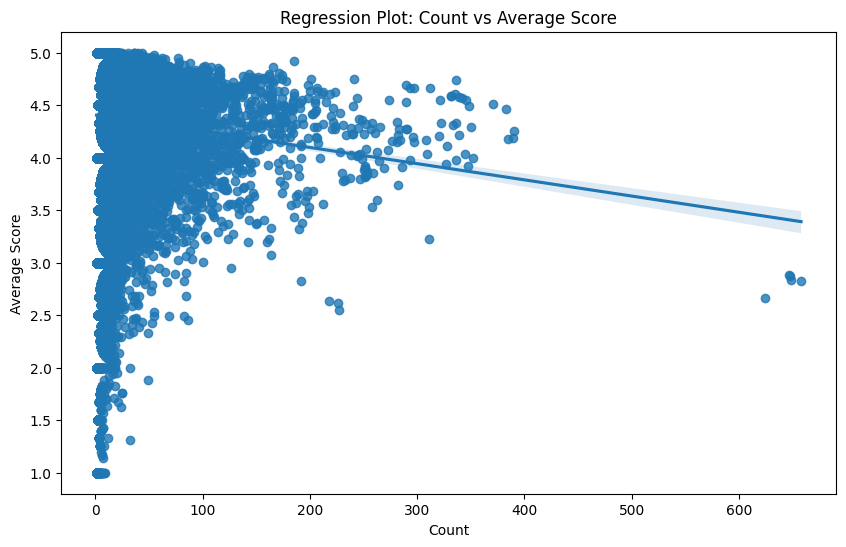

In [38]:
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.regplot(x="count", y="avg_score", data=ratings_df.to_pandas())
plt.title("Regression Plot: Count vs Average Score")
plt.xlabel("Count")
plt.ylabel("Average Score")
plt.show()

#### Comment:

- The correlation between the number of ratings and the ratings is negative.

In [39]:
uniq_titles_df: pl.DataFrame = merged_df.select(
    ["productId", "title", "product_category"]
).unique("title")
uniq_titles_df.shape

(187992, 3)

#### Create Metadata

- Metadata: product_category + summary + title

In [40]:
uniq_titles_df.head(2)

productId,title,product_category
str,str,str
"""B00006JUIZ""","""hawaiian style 2""","""music, pop music, world music"""
"""B00000IQ36""","""from the sun, acoustic guitar & ensemble""","""new age, music"""


In [41]:
product_tags_df: pl.DataFrame = merged_df.group_by("productId").agg(
    pl.col("summary").map_elements(lambda x: " ".join(x))
)
product_tags_df.head()

productId,summary
str,str
"""B00002SAQS""","""touching the soul"""
"""B000001INX""","""rock n roll!!!!!!!!! truly amazing intelligent punk rock for the independent punks out there... bes…"
"""B000MRM6FI""","""the definitive five royales cd"""
"""B000O3RPA6""","""excellent 1970s etta this album is all sex. ~riveting vocal masterpiece~bravo etta!!! classic etta"""
"""B00005AU5W""","""good album to appeal to salseros of all ages"""


In [42]:
products_df: pl.DataFrame = uniq_titles_df.join(
    product_tags_df, on="productId", how="left"
)
products_df = products_df.with_columns(
    genres=pl.col("product_category").str.replace_all(",", " "),
).with_columns(
    metadata=pl.concat_list(
        pl.col("summary"), pl.col("genres"), pl.col("title")
    ).map_elements(lambda x: " ".join(x))
)

products_df.head()

productId,title,product_category,summary,genres,metadata
str,str,str,str,str,str
"""B00006JUIZ""","""hawaiian style 2""","""music, pop music, world music""","""hawaiian style 2""","""music pop music world music""","""hawaiian style 2 music pop music world music hawaiian style 2"""
"""B00000IQ36""","""from the sun, acoustic guitar & ensemble""","""new age, music""","""simply wonderful""","""new age music""","""simply wonderful new age music from the sun, acoustic guitar & ensemble"""
"""B00000712T""","""mystical experience""","""music, rock music, pop music, dance & electronic music, alternative rock""","""it's still great graham!!""","""music rock music pop music dance & electronic music alternative rock""","""it's still great graham!! music rock music pop music dance & electronic music alternative r…"
"""B000A0QS8I""","""vanishing point (original 1989 11 track release)""","""music, hard rock & metal music, dance & electronic music, alternative rock""","""keep the fives coming!""","""music hard rock & metal music dance & electronic music alternative rock""","""keep the fives coming! music hard rock & metal music dance & electronic music alternative roc…"
"""B0001XAOS4""","""mantra of love (dig)""","""music, pop music, alternative rock music, dance & electronic music, classic rock music, rock""","""acid mothers temple - 'mantra of love' (alien8) amt""","""music pop music alternative rock music dance & electronic music classic rock music rock""","""acid mothers temple - 'mantra of love' (alien8) amt music pop music alternative rock music da…"


In [43]:
print(f"{products_df.shape = }")
products_df.select(["title", "metadata"]).head()

products_df.shape = (187992, 6)


title,metadata
str,str
"""hawaiian style 2""","""hawaiian style 2 music pop music world music hawaiian style 2"""
"""from the sun, acoustic guitar & ensemble""","""simply wonderful new age music from the sun, acoustic guitar & ensemble"""
"""mystical experience""","""it's still great graham!! music rock music pop music dance & electronic music alternative r…"
"""vanishing point (original 1989 11 track release)""","""keep the fives coming! music hard rock & metal music dance & electronic music alternative roc…"
"""mantra of love (dig)""","""acid mothers temple - 'mantra of love' (alien8) amt music pop music alternative rock music da…"


<br><hr>

### Content Based Recommender System

- Recommends items based on their characteristics and a user's preferences for those characteristics.
- Convert the text into vectors using TF-IDF.
- Reduce the dimensions using SVD.

In [44]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline


n_components: int = 200
seed: int = 123
pipe: Pipeline = Pipeline(
    [
        ("tfidf", TfidfVectorizer(stop_words="english", max_df=0.95, min_df=2)),
        ("svd", TruncatedSVD(n_components=n_components, random_state=seed)),
    ]
)
pipe

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')),
                ('svd', TruncatedSVD(n_components=200, random_state=123))])

In [45]:
latent_vectors = pipe.fit_transform(products_df["metadata"].to_numpy())
latent_vectors.shape

(187992, 200)

In [46]:
# latent_df: pd.DataFrame = pd.DataFrame(latent_vectors, index=products_df["title"])
title_df: pl.DataFrame = pl.DataFrame(
    data={
        "title": products_df["title"].str.to_lowercase(),
    }
)
latent_df: pl.DataFrame = pl.concat(
    [title_df, pl.DataFrame(latent_vectors)], how="horizontal"
)
latent_df.head()

title,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,column_37,column_38,column_39,column_40,column_41,column_42,column_43,column_44,column_45,column_46,column_47,column_48,column_49,column_50,column_51,column_52,column_53,column_54,column_55,column_56,column_57,column_58,column_59,column_60,column_61,column_62,column_63,column_64,column_65,column_66,column_67,column_68,column_69,column_70,column_71,column_72,column_73,column_74,column_75,column_76,column_77,column_78,column_79,column_80,column_81,column_82,column_83,column_84,column_85,column_86,column_87,column_88,column_89,column_90,column_91,column_92,column_93,column_94,column_95,column_96,column_97,column_98,column_99,column_100,column_101,column_102,column_103,column_104,column_105,column_106,column_107,column_108,column_109,column_110,column_111,column_112,column_113,column_114,column_115,column_116,column_117,column_118,column_119,column_120,column_121,column_122,column_123,column_124,column_125,column_126,column_127,column_128,column_129,column_130,column_131,column_132,column_133,column_134,column_135,column_136,column_137,column_138,column_139,column_140,column_141,column_142,column_143,column_144,column_145,column_146,column_147,column_148,column_149,column_150,column_151,column_152,column_153,column_154,column_155,column_156,column_157,column_158,column_159,column_160,column_161,column_162,column_163,column_164,column_165,column_166,column_167,column_168,column_169,column_170,column_171,column_172,column_173,column_174,column_175,column_176,column_177,column_178,column_179,column_180,column_181,column_182,column_183,column_184,column_185,column_186,column_187,column_188,column_189,column_190,column_191,column_192,column_193,column_194,column_195,column_196,column_197,column_198,column_199
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""hawaiian style 2""",0.044627,0.04595,-0.028495,0.011703,-0.016387,0.037706,0.088144,0.013929,0.025159,-0.005344,-0.042585,-0.002723,0.012212,-0.004784,0.010329,0.00022,0.002954,0.004247,-0.003794,0.0046,-0.004032,-0.001263,0.00025,-0.000756,-0.010301,0.005282,0.010091,-0.085456,0.026934,-0.018037,-0.009797,-0.001188,0.000599,0.001259,0.002187,-0.005128,0.01086,0.009071,0.00652,0.000765,-0.009293,0.018266,0.001938,0.009661,-0.017703,-0.002051,-0.00514,0.004937,-0.001673,0.002925,0.005871,0.012693,-0.002659,0.01342,-0.014453,0.004816,-0.001525,-0.012627,0.000184,-0.007666,-0.000184,-0.000254,-0.003746,0.002318,0.004714,-0.006634,-0.005318,-0.002919,-0.003443,0.003678,-0.010014,0.007316,-0.012888,-0.008596,0.000268,-0.001822,-0.004823,-0.000742,0.000489,0.000963,-0.002675,-0.004816,0.00133,0.00225,0.004069,-0.005671,-0.00619,-0.000358,0.000189,-0.005938,0.004285,-0.00489,-0.000979,0.001501,-0.001569,-0.006748,0.001114,0.005028,0.003955,-0.00357,0.001542,0.004776,-0.003022,0.005558,-0.000149,0.003924,0.001891,0.001046,0.000352,0.007626,-0.008248,0.000794,0.00867,0.001337,-0.001864,0.0

In [47]:
latent_df["title"].sample(n=8, seed=seed)

title
str
"""cold summer"""
"""i wonder if"""
"""circus"""
"""trouble people"""
"""brigade [japan import] [2 cd boxset]"""
"""edge of infinity"""
"""one for the ride"""
"""love is gonna getcha"""


In [48]:
import polars.selectors as cs


# Ignore the `title` column
latent_df.select(cs.float()).head()

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,column_37,column_38,column_39,column_40,column_41,column_42,column_43,column_44,column_45,column_46,column_47,column_48,column_49,column_50,column_51,column_52,column_53,column_54,column_55,column_56,column_57,column_58,column_59,column_60,column_61,column_62,column_63,column_64,column_65,column_66,column_67,column_68,column_69,column_70,column_71,column_72,column_73,column_74,column_75,column_76,column_77,column_78,column_79,column_80,column_81,column_82,column_83,column_84,column_85,column_86,column_87,column_88,column_89,column_90,column_91,column_92,column_93,column_94,column_95,column_96,column_97,column_98,column_99,column_100,column_101,column_102,column_103,column_104,column_105,column_106,column_107,column_108,column_109,column_110,column_111,column_112,column_113,column_114,column_115,column_116,column_117,column_118,column_119,column_120,column_121,column_122,column_123,column_124,column_125,column_126,column_127,column_128,column_129,column_130,column_131,column_132,column_133,column_134,column_135,column_136,column_137,column_138,column_139,column_140,column_141,column_142,column_143,column_144,column_145,column_146,column_147,column_148,column_149,column_150,column_151,column_152,column_153,column_154,column_155,column_156,column_157,column_158,column_159,column_160,column_161,column_162,column_163,column_164,column_165,column_166,column_167,column_168,column_169,column_170,column_171,column_172,column_173,column_174,column_175,column_176,column_177,column_178,column_179,column_180,column_181,column_182,column_183,column_184,column_185,column_186,column_187,column_188,column_189,column_190,column_191,column_192,column_193,column_194,column_195,column_196,column_197,column_198,column_199
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.044627,0.04595,-0.028495,0.011703,-0.016387,0.037706,0.088144,0.013929,0.025159,-0.005344,-0.042585,-0.002723,0.012212,-0.004784,0.010329,0.00022,0.002954,0.004247,-0.003794,0.0046,-0.004032,-0.001263,0.00025,-0.000756,-0.010301,0.005282,0.010091,-0.085456,0.026934,-0.018037,-0.009797,-0.001188,0.000599,0.001259,0.002187,-0.005128,0.01086,0.009071,0.00652,0.000765,-0.009293,0.018266,0.001938,0.009661,-0.017703,-0.002051,-0.00514,0.004937,-0.001673,0.002925,0.005871,0.012693,-0.002659,0.01342,-0.014453,0.004816,-0.001525,-0.012627,0.000184,-0.007666,-0.000184,-0.000254,-0.003746,0.002318,0.004714,-0.006634,-0.005318,-0.002919,-0.003443,0.003678,-0.010014,0.007316,-0.012888,-0.008596,0.000268,-0.001822,-0.004823,-0.000742,0.000489,0.000963,-0.002675,-0.004816,0.00133,0.00225,0.004069,-0.005671,-0.00619,-0.000358,0.000189,-0.005938,0.004285,-0.00489,-0.000979,0.001501,-0.001569,-0.006748,0.001114,0.005028,0.003955,-0.00357,0.001542,0.004776,-0.003022,0.005558,-0.000149,0.003924,0.001891,0.001046,0.000352,0.007626,-0.008248,0.000794,0.00867,0.001337,-0.001864,0.003641,-0.021757,0.013382,-0.00776

In [49]:
movie_title: str = "pirates of the caribbean: at world's end"
all_movie_vectors: np.ndarray = latent_df.select(cs.float())
movie_vector: np.ndarray = latent_df.filter(pl.col("title").eq(movie_title)).select(
    cs.float()
)
print(f"{movie_vector.shape = }")
print(f"{all_movie_vectors.shape = }")
# V @ m -> (234564, 200) @ (1, 200)
# V @ mT -> (234564, 200) @ (200, 1) -> (234564, 1)
cos_sim: float = cosine_similarity(latent_df.select(cs.float()), movie_vector)
print(f"{cos_sim.shape = }")
similarity_measure_df: pl.DataFrame = pl.DataFrame(
    {"title": latent_df["title"], "similarity": cos_sim.flatten()}
).sort(by="similarity", descending=True)

similarity_measure_df.head()

movie_vector.shape = (1, 200)
all_movie_vectors.shape = (187992, 200)
cos_sim.shape = (187992, 1)


title,similarity
str,f64
"""pirates of the caribbean: at world's end""",1.0
"""fight club: original motion picture score""",0.762823
"""gladiator""",0.7605
"""the last of the mohicans: original motion picture soundtrack""",0.753474
"""the mission: original soundtrack from the motion picture""",0.751225


In [50]:
# Reccommend movies to users based on their preferences
N: int = 10
columns: list[str] = ["title", "product_category"]
recommend_df: pl.DataFrame = (
    similarity_measure_df.join(products_df.select(columns), on="title", how="left")
    .slice(0, N)
    .select(columns + ["similarity"])
)
recommend_df

title,product_category,similarity
str,str,f64
"""pirates of the caribbean: at world's end""","""music, soundtracks music, pop""",1.0
"""fight club: original motion picture score""","""music, dance & electronic music, soundtracks music, pop""",0.762823
"""gladiator""","""music, soundtracks""",0.7605
"""the last of the mohicans: original motion picture soundtrack""","""music, pop music, soundtracks""",0.753474
"""the mission: original soundtrack from the motion picture""","""music, pop music, soundtracks""",0.751225
"""desperado: the soundtrack""","""music, pop music, latin music music, soundtracks music, world music music, rock""",0.737777
"""queen of the damned""","""music, soundtracks music, pop music, hard rock & metal""",0.7344
"""the prince of egypt: music from the original motion picture soundtrack""","""music, pop music, broadway & vocalists music, soundtracks""",0.733919
"""pirates of the caribbean: the curse of the black pearl""","""music, children's music music, soundtracks music, pop""",0.731593


In [51]:
products_df.filter(pl.col("title").str.contains("pirates of the caribbean"))

productId,title,product_category,summary,genres,metadata
str,str,str,str,str,str
"""B000P0J02E""","""pirates of the caribbean: at world's end""","""music, soundtracks music, pop""","""very good best of the pirate scores beyond words awesome score! amazing! arrrrg pickles drink up me…","""music soundtracks music pop""","""very good best of the pirate scores beyond words awesome score! amazing! arrrrg pickles drink up me…"
"""B0000A1RJI""","""pirates of the caribbean: the curse of the black pearl""","""music, children's music music, soundtracks music, pop""","""brings the movie to life! highly recommend!! great sound but not too original like watching the mov…","""music children's music music soundtracks music pop""","""brings the movie to life! highly recommend!! great sound but not too original like watching the mov…"
"""B000N0KVP6""","""pirates of the caribbean: dead man's chest (ost)""","""music, soundtracks music, children's music""","""a must have for any soundtrack collection shiver me timbers! pirates of the caribbean soundtrack th…","""music soundtracks music children's music""","""a must have for any soundtrack collection shiver me timbers! pirates of the caribbean soundtrack th…"
"""B000U1ZIUQ""","""music from the pirates of the caribbean trilogy""","""music, soundtracks music, pop music, classic rock music, rock""","""music from the prates of the caribbean triology one of the best soundstracks around! music from pir…","""music soundtracks music pop music classic rock music rock""","""music from the prates of the caribbean triology one of the best soundstracks around! music from pir…"
"""B000FS9N1E""","""great pirate music: music inspired by pirates of the caribbean""","""music, miscellaneous music, alternative rock music, rock""","""party music love it!""","""music miscellaneous music alternative rock music rock""","""party music love it! music miscellaneous music alternative rock music rock great pirate music…"
"""B000FNNNGU""","""pirates of the caribbean: dead man's chest""","""music, soundtracks""","""good listening great music not nearly as good as the first soundtrack moving music best movie sound…","""music soundtracks""","""good listening great music not nearly as good as the first soundtrack moving music best movie sound…"


### Collaborative Filtering

- Collaborative filtering is a recommendation system technique that suggests items (like movies, products, or music) to users based on the preferences of similar users.
- The core idea is that if two users have similar tastes, they are likely to enjoy the same items.

#### Types of Collaborative Filtering

- There are primarily two main types of collaborative filtering:

  - `Memory-Based Collaborative Filtering`: This approach directly compares users or items to find similarities and make recommendations.
    - User-based: Finds users with similar tastes and recommends items that similar users liked.
    - Item-based: Finds items similar to those a user has liked and recommends those similar items.
  
  - `Model-Based Collaborative Filtering`: This approach builds a model from the data and uses it to make predictions.
    - Matrix Factorization: Represents users and items as vectors in a latent space and tries to predict missing ratings based on these vectors.
    - Clustering: Groups users or items into clusters based on similarity and makes recommendations based on cluster information.


<br>

#### Memory Based Colaborative Recommenders

- Filter out users with less than `X` number of ratings.
- Select unique products rated by users with `X` or more ratings.

In [52]:
music_cleaned_df["userId"].value_counts().describe()

statistic,userId,count
str,str,f64
"""count""","""457336""",457336.0
"""null_count""","""0""",0.0
"""mean""",null,2.234174
"""std""",null,9.031317
"""min""","""A00300183FZS8SG216L1X""",1.0
"""25%""",null,1.0
"""50%""",null,1.0
"""75%""",null,2.0
"""max""","""http://www.amazon.com/review/R2N4MKSSZEJ0VW""",2085.0


In [53]:
activity_threshold: int = 5
user_activity: list[str] = (
    music_cleaned_df["userId"]
    .value_counts(sort=True)
    .filter(pl.col("count").ge(activity_threshold))
)["userId"].to_list()

# Select active users
music_active_df: pl.DataFrame = music_cleaned_df.filter(
    pl.col("userId").is_in(user_activity)
)
print(f"{music_active_df.shape = }")
uniq_products_df: pl.DataFrame = music_active_df.unique(subset=["productId"])
print(f"{uniq_products_df.shape = }")

# Ratings for unique products
ratings_df: pl.DataFrame = music_active_df.filter(
    pl.col("productId").is_in(uniq_products_df["productId"])
).select(["userId", "productId", "score"])
print(f"{ratings_df.shape = }")

ratings_df.head()

music_active_df.shape = (422065, 10)
uniq_products_df.shape = (143442, 10)
ratings_df.shape = (422065, 3)


userId,productId,score
str,str,f32
"""A1UC15EDQ30TNB""","""B000069AZM""",5.0
"""A1LBL3FA5PX7EN""","""B0000AGWG0""",4.0
"""A2T2LY2HHWBIGO""","""B0002B74UG""",4.0
"""A2AIMXT9PLAM12""","""B00004SA89""",3.0
"""A32DTCFBBB9WIV""","""B00005HEFU""",5.0


In [54]:
ratings_pivot_df: pl.DataFrame = ratings_df.pivot(
    index=["productId"], columns="userId", values="score"
).fill_null(0)
ratings_pivot_df.head(10)

productId,A1UC15EDQ30TNB,A1LBL3FA5PX7EN,A2T2LY2HHWBIGO,A2AIMXT9PLAM12,A32DTCFBBB9WIV,AKR6UK8O6DM6X,AYTGG6XTVUG7G,A34ZAYTNP67S83,A1O9E4H4NFTMI4,A2MPDZNDDRNC4B,A8IFUOL8S9BZC,A2C02UUAU5B22C,A278BQVTXK999P,A3UXDKQONZIBZN,A3B21LIIKU1W4T,A1K9F885OTGKNO,A4HYUXRZKM33V,AGEIT17HENDIS,A3VUXYHJGL9WWX,AJSK0W7KQ19G1,A2QH5NMHW1KTJ1,A22VNXHU6IZ5MT,A121X1GOQV01DW,A386WE9MECYL3G,A3H1O5A9BA9C2K,A2JJP3PXH7A0WX,A1NVEW628JUS2Y,A1Y8FBJLVK6LS9,AY9BXUKJVPQTD,A1S9CW78YQRK2C,A14U40MX3CPO8Q,A1FQR15M2TXFFZ,A1W5U6443BKM84,A6WLAFN9R2XEG,AW7D2VPNOGD8E,AVUKI21HQW68U,AIO247KHD2O40,AETJY54Y4WIGN,AE0NM5F9U6PQE,A1PMGN6081PLAS,A2ZQAJOAV8FLCY,A1AL15PY5AVFNX,ARDKWR8F9UW3,A3FWHXSZSTKFIU,A1ZJJL01LVZQGU,A1ZS82R4RC0I2N,AHS5EDSIFKB8A,A2YARCE69AJTVB,A13H2JJ3GEMJN1,AQP1VPK16SVWM,A2ZROE1C2KHMIT,A28FW6Z8FR5Q9J,AZ1MNRUSHHTKA,A13M2OZU0IWFY8,A6RGSYB31TJON,A2URKWCL5YZNWO,AF74UAKV3Q3W0,A1ITGS41RAFCF4,A38KB16DRKI8QW,AQAJCIW3WBJQN,A158DXY00QSWV9,A3T75J90CCIVUU,A2FEUSZVIVVYOR,A18IZ5QX2PRB3C,A24Q55SGLTG5LH,A16CZRQL23NOIW,A3A62CRYFKJUSQ,AL7LEBKKW8XCC,A3P34RLGL3EO8Q,A2TD13LRUGU46X,A23RSMK1FFMJSJ,A16XRPF40679KG,A175TPTHMNS7S4,A1M0EQWAYGVNVR,A2JBDC1OR1KZGP,A24M6HHB6FEC45,A340H40KL7X4OO,ARYB7XIK82XM2,A1I4J70BNSULM2,A2SOHJP90T5YYS,A1GYB7BF3JZQA6,A1HFVQZIDK7UUD,AQLJ566RYMQ2M,A27950GV5XJ1T5,AHN34TYB15NWF,AR4GHV6PXQMYR,A17VT4LMOZ5AN2,A1YRLTQX3ZXC9C,A3LGT0FSQ3IDJO,AYF76HQ10BL2J,A1F2IPYSXB0ZCX,AFTN9ZLB22PSZ,A2WLZD9BY669HY,AWO5KNSDF6S0J,ATC69EUL68BEF,A1IWWRZJOXOSYP,A138I6EVRRRR5I,A6FZZ43GZPF9J,A1D2C0WDCSHUWZ,AEMQWKFIFJM8G,AGEJE3WH26UBR,A2WKKTVYS5H61M,A3ERVC5N6L0487,A30XZO9A3H5BYH,AQ9T9A5WJXVA9,A3K90XT4IM01GE,A2JENEL7JFMWGP,AHM4U06NBXGWM,A37F6PQRBCAKL6,A1GN8UJIZLCA59,A2Y8N3DTQGVSOC,A188XNV7VNF86X,A3AUECYM0M0YSX,A2SPVJ5NYCOY00,AS4UPQG2B0Y2I,A8KQFDL7D81KR,A2Z125PVH4WZE7,A36SSF310LBGSE,A3W4D8XOGLWUN5,A2PWYXDTN96G8V,A2116N4G8H9ABN,AVLXIA3WG1OHN,A3DL686B8JEM8A,A3GTI1Z7YE49ZS,A1H7ZGGYBNBZYH,A3VQSFORKH8B7O,A3KKM0T1KY42HA,AAZ7PNPA37K2R,A259OYCZMAH97E,A32XSKO7TOI0BH,ASVNSWIXBV72Q,AEN49O6S7YKN4,A3464G00K8ZYD1,A3HY4TPGWGZ8BV,AOTWLML7LR4N0,A3RM2O1W0NMCXX,A3LFCXR5GX7H3E,A3AXPB7OPZNOP4,A1Y0KQLFPHSM2B,A3A43DRT4FA0SG,AP4167JEAUHIX,AI1VD7QWKM0V1,A1TC5EBGPW13UJ,A1TOML01ZYPUFR,A2J78MF9FQ58ZK,A24L67L2WIWJ5W,A2Y2TBF8ZD07OK,A3QWNQ2WA7QZYJ,A1SD82ZAT3INZ2,A2VF10N9EM6WHS,A2BT578J4IZOK6,A11XKY4EIU2KNR,A1906RZITWT2K2,ANTEI30O73HZU,A1QXUQZP4XTI5X,A1VQBHHXIKHIGS,A1WLZYEOIL1HLT,ACUCLUBXUWB6O,ACGL5OYM023MK,AD39QGHGWAOPQ,ANHVE4JUUNJRI,A2IXW3WVVJ5SBY,A2TP4A79ZRVTHV,A1Y0ZGLUSMXNJR,AYT4YLB36MY4J,A3VHV0NV7NKQPC,A1JBC0F8VFNDOH,APYSIHJ4456CA,A2OUOKKUDJ6KOL,A97B72F4UI8FA,AORCXT2CLTQFR,A80KX5NR2EUPY,A3HGDTNR54K3V4,A25NAXA5TGI078,A49XO4MO130OS,A5KJVGJ43ZDC9,A1FXPZ5K1C1NBY,A3N0E03AQD128O,A3ANHRLMPJKF6G,A27QLZM3536H67,A276M3NSIY9B82,A16TZWT3O4CFBD,A19VI8M7BQKHDZ,A3TP4ADHTP9V4X,AQLKBEVHUQ0JK,A1LFRJ3CSQFCI6,A3IPO6P4LHZ0NS,A9Q28YTLYREO7,A1501GO004MI7U,A2JLSHTST2SP1I,A13A81NN0NRD1S,A3JLTHN4FEU6OE,A38OKIE3HRGUW0,A24N1BAS3CU27H,A1432KCCCZL550,A3T1CQ54GSLFA2,A2A2IQJJNPQ068,A3R0Z2ZU5XDQRX,A1TMBL415E3G28,A3JNGH6839T0GU,A1UF7GNJ8M3ZCF,A2U5BZYHOCKLOO,AJXZ7O1TIFXWH,A2R3TIKDQ3W689,AK6CR5AU9BGG2,A20YK56HZSHXEK,A1AKFSADXXEWWX,A1YI1CILAWF1A4,A38ZNHOJMXWHR2,AS0S9RXLW6K4H,A2PCT57MWSAGX2,A2PUJ3949R1HT4,A3THHNVPKRYT4D,A17C2PSO00UAAQ,A26TBR6WWBKVEI,A3ON8MAVTO2694,A228WXJJ28YKB2,A2K6M9HI7PZC0N,A28FNKCGFS03VL,A3QDA8MTAD943Z,A1J5KCZC8CMW9I,A1RX7FAEDSI5IX,ADS5APY1NKTL4,AMFRF5EIX2PCG,A26T3K49OTBGWY,A17FV9DKNKGGQL,A1JF78EP4GPAOO,AYCUV7F3QC482,A25XTLUNEH4OFC,A3CYAA27XVVTS5,A25PM9JGHPU8EI,AOF3037PWFAAP,A2WTENUXV4W86F,A1V06OFK624OWQ,A3FY3H6F4249E0,A26XCS3QLDJJWN,A1Z1YA3C8NWC36,A1AFKAV50TOB43,A1EPTOYTJ1K2ZM,A3OZKAQ20U5KNL,A1VYFBHW6OHA59,A2E0E4Z1DLFL6J,A1KDPZ64WRIEXC,A3TKL7X26QKKMO,ASD8JA3IBRIKJ,A17V4Y08XT8THU,AFLAIV5URQSDV,AOILH3TKJNAKB,A39KES33IH1GXR,AOMVHELVPK1IX,A28TV70E5LJ1Q7,A8EDTKSPOMRWK,A3QZ4ID39UXR1Z,A4PTUEVFE13K6,A1NH8RA9ORRC3W,A2T7ID3HI4FSZ3,A30HZR8R7OHJMM,A2LAAAAE0UQZP0,A19HQVND02SRWE,A3LEVOCJ6J45LU,A3ROZK0G84RGMZ,A242HJZT957JP7,A3OIC7GUFY941R,AKON7YTSYRU2Y,ADKHI1TUGAX4,A2UR38SZPVA07I,A3TSPLFYU2UMW0,A3M10QDX3D63AO,A1OB5L3WMHJAD9,AH24HR3A19LP5,A2YF62MC48SVDN,

In [55]:
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler


# Convert the Polars DataFrame to a NumPy array
ratings_np: np.ndarray = ratings_pivot_df.select(cs.float()).to_numpy()

# Convert to a sparse CSR matrix
sparse_matrix: csr_matrix = csr_matrix(ratings_np)

# Standardize the data (centering and scaling)
# Note: with_mean=False because sparse matrices can't support mean centering efficiently
scaler: StandardScaler = StandardScaler(with_mean=False)
sparse_standardized = scaler.fit_transform(sparse_matrix)

# Compute the correlation matrix
n: int = sparse_matrix.shape[0]
corr_matrix = (sparse_standardized.T @ sparse_standardized) / (n - 1)

print("Correlation matrix shape:", corr_matrix.shape)
print(corr_matrix.toarray())  # Convert to dense format for easy viewing if needed

Correlation matrix shape: (29173, 29173)
[[1.0001 0.     0.     ... 0.     0.     0.    ]
 [0.     1.0005 0.     ... 0.     0.     0.    ]
 [0.     0.     1.0001 ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 1.     0.     0.    ]
 [0.     0.     0.     ... 0.     1.     0.    ]
 [0.     0.     0.     ... 0.     0.     1.    ]]


In [56]:
a

NameError: name 'a' is not defined

In [ ]:
# # Calculate the correlation
# corr_array: np.ndarray = np.corrcoef(ratings_pivot_df.select(cs.float()).to_numpy())
# corr_array.shape

In [ ]:
# # Calculate the correlation
# corr_df: pl.DataFrame = pl.DataFrame(corr_array)
# corr_df.head()